# Load data using Data Genrator

In [1]:
import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.metrics import classification_report
import numpy as np
from sklearn.utils import shuffle
from keras import regularizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import keras.layers as Layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.optimizers as Optimizer
print(tf.__version__)
from keras import applications
from tensorflow import keras

# stacked generalization with linear meta model on blobs dataset
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from keras.models import load_model
from keras.utils import to_categorical
from numpy import dstack

TensorFlow version is  2.4.1
2.4.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load COVID-19 X-ray images

In [3]:
def dataGen(batch, path) :
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    # All images will be rescaled by 1./255
    train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15,  
                                       width_shift_range=0.4,height_shift_range=0.3, horizontal_flip=True,
                                       shear_range=0.2, zoom_range=0.2)
    # fit the data augmentation
    #train_datagen.fit(x_train)
      
    valid_datagen = ImageDataGenerator(rescale=1./255)#,featurewise_center=True, 
                                       #featurewise_std_normalization=True, rotation_range=20,   
                                       #width_shift_range=0.2,height_shift_range=0.2, horizontal_flip=True)

    test_datagen = ImageDataGenerator(rescale=1./255)
    size=(224,224)
        
    train_generator = train_datagen.flow_from_directory(
            path+'train',  # This is the source directory for training images
            target_size=size,  # All images will be resized to 150x150
            batch_size=batch,
            # Since we use binary_crossentropy loss, we need binary labels
            class_mode='categorical')
    label_map = (train_generator.class_indices)

    test_generator = test_datagen.flow_from_directory(
            path+'test/',  # This is the source directory for training images
            target_size=size,  # All images will be resized to 150x150
            batch_size=batch,
            # Since we use binary_crossentropy loss, we need binary labels
            class_mode='categorical',
            shuffle=False)

    valid_generator = valid_datagen.flow_from_directory(
            path+'validation/',  # This is the source directory for training images
            target_size=size,  # All images will be resized to 150x150
            batch_size=batch,
            # Since we use binary_crossentropy loss, we need binary labels
            class_mode='categorical')
    return train_generator, test_generator, valid_generator


path='/content/drive/MyDrive/Covid_X-ray-Image/'
train_generator, test_generator, valid_generator = dataGen(16,path)


Found 438 images belonging to 2 classes.
Found 125 images belonging to 2 classes.
Found 62 images belonging to 2 classes.


# Displaying Some images

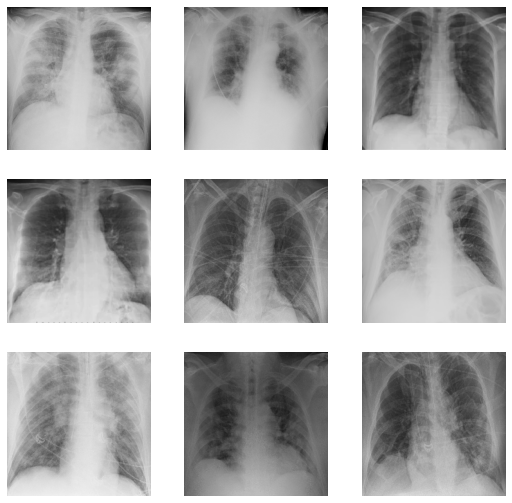

In [4]:
Images, labels = test_generator.next()

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 3
ncols = 3

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)

for i in range(9):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = Images[i]
  plt.imshow(img)

plt.show()

# Use_PreTrain_model()

In [5]:
def use_PreTrain_model(): 
    import tensorflow as tf
    img_height,img_width = 224,224 
    IMG_SHAPE = (img_height,img_width, 3)
    inp = tf.keras.Input(shape=(img_height,img_width, 3))
    inp2 = tf.keras.layers.Concatenate()([inp, inp, inp])

    
    base_model = tf.compat.v2.keras.applications.VGG19(include_top=False, weights='imagenet', input_tensor=None, input_shape=IMG_SHAPE, pooling=None, classes=1000)
    #base_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=IMG_SHAPE, pooling=None, classes=1000)
     
        
    base_model.trainable = True
    # Let's take a look to see how many layers are in the base model
    print("Number of layers in the base model: ", len(base_model.layers))
    # Fine-tune from this layer onwards
    fine_tune_at =18

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable =  False
         
    model = tf.keras.Sequential([
          base_model,
          keras.layers.Conv2D(512, (3, 3), activation='relu'),
          keras.layers.Conv2D(512, (3, 3), activation='relu'),

          keras.layers.GlobalAveragePooling2D(),
          #MCDropout(rate=0.5),
          keras.layers.Dense(2, activation='softmax')
    ])
    return model 
#model.summary()

# Transfer learning

In [ ]:

model = use_PreTrain_model()
n_epochs =10

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001, decay=1e-6),
              loss='binary_crossentropy',metrics=['Accuracy'])# define learning rate callback


history = model.fit_generator(train_generator, epochs=n_epochs, verbose= 1, shuffle = True, 
                              validation_data = valid_generator,steps_per_epoch=27,
                              validation_steps=2)

#model.save('/content/drive/MyDrive/Covid_X-ray-Image/vgg_model.h5')


Number of layers in the base model:  22


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
20/20 [==============================] - 12s 578ms/step - loss: 0.6106 - accuracy: 0.0010 - val_loss: 0.3982 - val_accuracy: 0.0000e+00
Epoch 2/50
20/20 [==============================] - 11s 549ms/step - loss: 0.4333 - accuracy: 0.0068 - val_loss: 0.9057 - val_accuracy: 0.0000e+00
Epoch 3/50
20/20 [==============================] - 11s 551ms/step - loss: 0.3519 - accuracy: 0.0636 - val_loss: 0.2031 - val_accuracy: 0.0000e+00
Epoch 4/50
20/20 [==============================] - 11s 557ms/step - loss: 0.2453 - accuracy: 0.1039 - val_loss: 0.1432 - val_accuracy: 0.0000e+00
Epoch 5/50
20/20 [==============================] - 12s 587ms/step - loss: 0.3340 - accuracy: 0.0441 - val_loss: 0.2168 - val_accuracy: 0.0000e+00
Epoch 6/50
20/20 [==============================] - 11s 540ms/step - loss: 0.2570 - accuracy: 0.0213 - val_loss: 0.2078 - val_accuracy: 0.0469
Epoch 7/50
20/20 [==============================] - 11s 563ms/step - loss: 0.2696 - accuracy: 0.0690 - val_loss: 0.0386 - 

In [10]:
# evaluate the model
model = load_model('/content/drive/MyDrive/Covid_X-ray-Image/vgg19_model-1.h5')

_, test_acc = model.evaluate(test_generator, verbose=0)

print('Test: %.3f' % (test_acc))


Test: 0.968


# Performances Assisment

In [11]:
from sklearn.metrics import confusion_matrix
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import classification_report
from imblearn.metrics import geometric_mean_score
import seaborn as sn
import pandas as pd
#model = load_model('../input/stack-cnn-submodels/vgg19/vgg19/vgg_F5_model_9.h5')
test_generator.reset()
pred = model.predict_generator(test_generator, verbose=0, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False)

pred_label=np.argmax(pred,axis=1)
true_label = test_generator.classes

loss, acc = model.evaluate_generator(test_generator,steps=None)

target_names = ['COVID19',  'Normal']
result = sensitivity_specificity_support(true_label, pred_label, average='macro')

print("Sensitivity: {:5.2f}%".format(100*result[0]), "specificity {:5.2f}%".format(100*result[1]), 
      "Accuracy: {:5.2f}%".format(100*acc),'\n')

report=classification_report(true_label, pred_label, target_names=target_names, digits=4)
print(report)


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

Sensitivity: 92.00% specificity 92.00% Accuracy: 96.80% 

              precision    recall  f1-score   support

     COVID19     1.0000    0.8400    0.9130        25
      Normal     0.9615    1.0000    0.9804       100

    accuracy                         0.9680       125
   macro avg     0.9808    0.9200    0.9467       125
weighted avg     0.9692    0.9680    0.9669       125

